# Reducers

## Experiment
The goal of the second experiment is to find the best number of composites in conjunction with the best temporal reducers that are beneficial in predicting leaf type mixture as a regression problem. The experiment assumes the following:

- A time window of 1 year is chosen, starting with 1. April, 2017, thus covering all seasons. April of 2017 was the first whole month with Level-2A imagery and the closest to the recording dates.
- Level-2A Sentinel 2 satellite imagery and indices determined by the previous experiment are used as input features.
- Random Forest from scikit-learn with default parameters is chosen as the regression model.
- The evaluation metrics for the model are RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and R2 (Coefficient of Determination).

The experiment is conducted on 1 to 12 composites in 1 step intervals with the following temporal reducers:

In [1]:
# List the available reducers (except for reducers with a NonNull variant)
from ltm.data import list_reducers

reducers = list_reducers()
reducers = [reducer
            for reducer in reducers
            if not reducer + "NonNull" in reducers]

reducers

['And',
 'Or',
 'allNonZero',
 'anyNonZero',
 'circularMean',
 'circularStddev',
 'circularVariance',
 'count',
 'countDistinctNonNull',
 'countRuns',
 'firstNonNull',
 'kendallsCorrelation',
 'kurtosis',
 'lastNonNull',
 'max',
 'mean',
 'median',
 'min',
 'minMax',
 'mode',
 'product',
 'sampleStdDev',
 'sampleVariance',
 'skew',
 'stdDev',
 'sum',
 'variance']

In [2]:
# List the bands determined by the previous experiment
from ltm.models import bands_from_importance

sentinel_bands, index_bands = bands_from_importance("../reports/band_importance.csv")

sentinel_bands, index_bands

Initializing Earth Engine API...


(['B9', 'TCI_G'],
 ['BAIM',
  'BWDRVI',
  'GCC',
  'MCARI705',
  'MGRVI',
  'MIRBI',
  'MLSWI26',
  'MNLI',
  'MTCI',
  'NBRplus',
  'NDCI',
  'NDDI',
  'NDGI',
  'S2WI',
  'SIPI',
  'TRRVI',
  'TTVI',
  'WI2015',
  'kEVI',
  'kIPVI',
  'kNDVI',
  'kVARI'])

In [3]:
from ltm.data import sentinel_composite, split_band_name
from ltm.features import load_raster, interpolate_X, drop_nan_rows, to_float32
from time import sleep

from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from pathlib import Path
import pandas as pd
from itertools import product
from datetime import datetime
import numpy as np

model = RandomForestRegressor(n_jobs=-1, random_state=42)
search_space = {
    "time_window": [(datetime(2017, 4, 1), datetime(2018, 4, 1))],
    "num_composites": list(range(1, 13))[::-1],  # Reverse to start with slowest
    "temporal_reducers": [[reducer] for reducer in reducers],
    "indices": [index_bands],
    "sentinel_bands": [sentinel_bands],
}
scoring = {
    "R2 Score": make_scorer(r2_score),
    "Mean Absolute Error": make_scorer(mean_absolute_error),
    "Root Mean Squared Error": make_scorer(mean_squared_error, squared=False)
}
y_path = "../data/processed/ground_truth/y.tif"

def create_X(y_path, search_point):
    # Create X_path and ensure directory exists
    reducer = search_point["temporal_reducers"][0]
    composites = search_point["num_composites"]
    X_path_to = f"../data/processed/reducer_composites/X_{reducer}_{composites}.tif"
    Path(X_path_to).parent.mkdir(parents=True, exist_ok=True)

    # Create the composite
    if not Path(X_path_to).exists():
        sleep_time = 60
        while True:
            try:
                sentinel_composite(
                    y_path_from=y_path,
                    X_path_to=X_path_to,
                    **search_point
                )
                break
            except Exception:
                sleep(sleep_time)
                sleep_time *= 2
                pass

    # Fill missing values by linear (circular) interpolation
    X = load_raster(X_path_to)
    interpolated_X = interpolate_X(X)
    interpolated_X = to_float32(interpolated_X)
    
    return interpolated_X

def check_row_exists(search_point):
    try:
        df = pd.read_csv("../reports/reducer_composites.csv")
        for i, row in df.iterrows():
            if list(row[:2]) == [search_point["temporal_reducers"][0], search_point["num_composites"]]:
                return True
        
        return False
    except FileNotFoundError:
        return False

def callback(scores, scoring, search_point):
    # Scores and Parameters of the current search point

    # Read the reducer_composites.csv
    reducer_composites = "../reports/reducer_composites.csv"
    try:
        df = pd.read_csv(reducer_composites)
    except FileNotFoundError:
        columns = ["Reducer", "Composites"] + list(scoring.keys())
        df = pd.DataFrame(columns=columns)

    # Store the scores in the dataframe
    first_columns = [search_point["temporal_reducers"][0], search_point["num_composites"]]
    last_columns = [scores[f"test_{key}"].mean() for key in scoring.keys()]
    idx = len(df)
    for i, row in df.iterrows():
        if list(row[:2]) == first_columns:
            idx = i
    df.loc[idx] = first_columns + last_columns

    # Save to CSV
    df.to_csv(reducer_composites, index=False)

def grid_search(model, search_space, scoring, y_path, create_X=create_X, callback=callback):
    y = load_raster(y_path)

    params = search_space.keys()
    for values in tqdm(list(product(*search_space.values()))):
        search_point = dict(zip(params, values))

        # Skip if the row already exists
        if check_row_exists(search_point):
            continue
        
        X = create_X(y_path, search_point)
        if len(X.dropna(axis=1).columns) > 0:
            X.dropna(axis=1, inplace=True)
        X_no_nan, y_no_nan = drop_nan_rows(X, y)

        if len(X_no_nan) < 5:
            scores = {f"test_{key}": np.full(1, np.nan) for key in scoring.keys()}
        else:
            scores = cross_validate(model, X_no_nan, y_no_nan, scoring=scoring, n_jobs=-1)
        callback(scores, scoring, search_point)

grid_search(model, search_space, scoring, y_path)

100%|██████████| 324/324 [00:03<00:00, 83.80it/s] 


In [4]:
# Use science style
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")

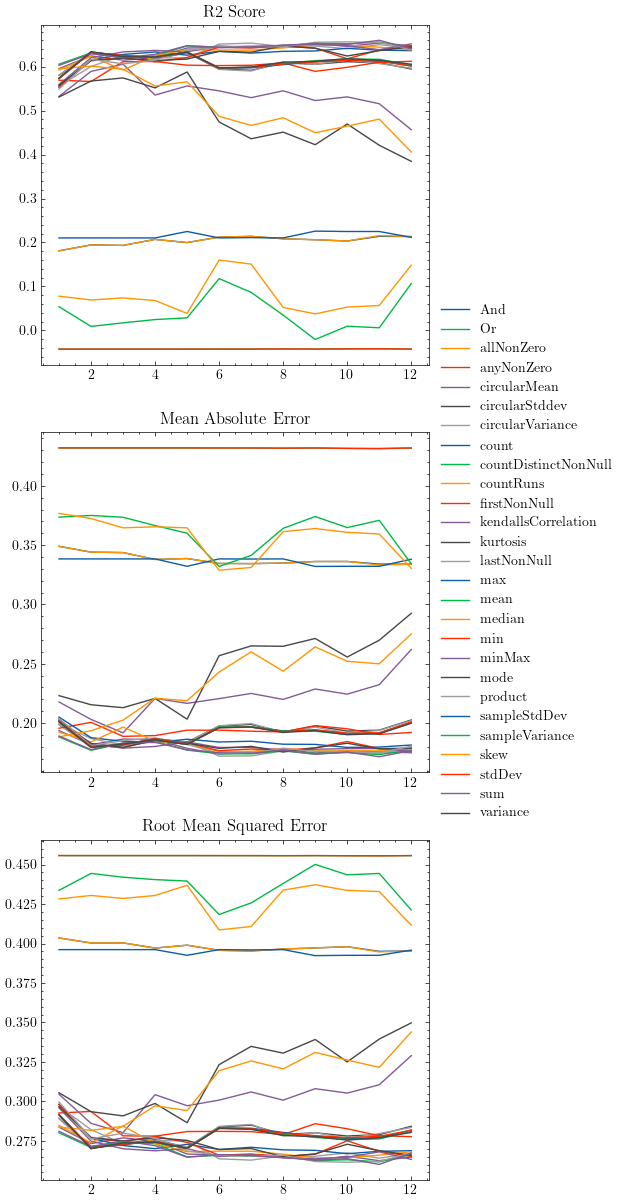

In [5]:
# Draw one multiline plot per metric with all gray lines except for the 5 best reducers
import pandas as pd

df = pd.read_csv("../reports/reducer_composites.csv")

dfs = {}
for i, (metric, scorer) in enumerate(scoring.items()):
    new_df = pd.DataFrame(index=df["Composites"].unique()[::-1])
    
    grouped = df[["Reducer", "Composites", metric]].groupby("Reducer")
    for name, group in grouped:
        group = group.sort_values("Composites")
        new_df[name] = np.asarray(group[metric])

    dfs[metric] = new_df

fig, axes = plt.subplots(len(scoring), 1, figsize=(5, 5*len(scoring)))
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

for ax, metric in zip(axes, dfs.keys()):
    dfs[metric].plot(ax=ax, title=metric, legend=False)

golden_ratio = (1 + 5**0.5) / 2
axes[1].legend(loc="center left", bbox_to_anchor=(1, 1 / golden_ratio))

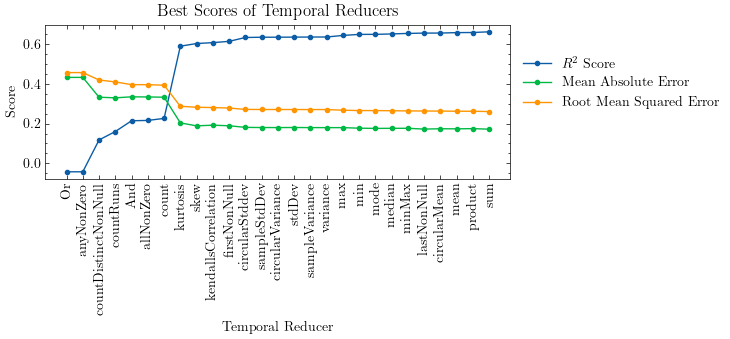

In [6]:
from ltm.models import plot_report
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")

plt_df = pd.DataFrame({
    "R2 Score": dfs["R2 Score"].max(),
    "Mean Absolute Error": dfs["Mean Absolute Error"].min(),
    "Root Mean Squared Error": dfs["Root Mean Squared Error"].min()
})

ax = plot_report(
    plt_df.sort_values("R2 Score"),
    "Best Scores of Temporal Reducers",
    "Temporal Reducer",
    "Score",
    label_rotation=90,
    replace_labels={"R2 Score": "$R^2$ Score"},
    figsize=(6, 2),
    marker=".",
)

plt.show()

# Interpretation of the Results

We decide to discard following reducers:
- quantitative and logical reducers that only consider the presence/absence of images, but not the actual values of the pixels, which are
- all variance and stdDev reducers, with the exception of sampleVariance. They all correlate highly, circular does not make much sense as the data is not in radians, without "sample" prefix, it is not as accurate for small sample sizes. Variance performed better than stdDev in most cases.
- firstNonNull and lastNonNull reducers, which are highly dependent on the weather conditions on the first and last image respectively.
- circular reducers, which are not applicable to the bands of the Sentinel-2 satellite imagery, as the intensities are not radians angles.
- kendallsCorrelation as it is NaN
- statistical reducers for population statistics, where a sample version exists
- "sum" is highly correlated with "mean"
- "product" is, like "sum", sensitively depend on the number of available images for a composite
- MinMax as it combines min and max, which are already present as reducers

In [7]:
# Define all reducers that come into question
reducers = [
    "median",
    "mean",
    "mode",
    "min",
    "max",
    "sampleVariance",
    "kendallsCorrelation",
    "skew",
    "kurtosis",
]

In [8]:
# Find the best number of composites for each reducer
best_composites = pd.DataFrame()

for metric in scoring.keys():
    if metric == "R2 Score":
        best_composites[metric] = dfs[metric][reducers].idxmax()
    else:
        best_composites[metric] = dfs[metric][reducers].idxmin()
best_composites["Smallest Number of Composites"] = best_composites.min(axis=1)

best_composites

,R2 Score,Mean Absolute Error,Root Mean Squared Error,Smallest Number of Composites
median,9,6,9,6
mean,11,11,11,11
mode,8,8,8,8
min,8,6,8,6
max,10,10,10,10
sampleVariance,2,2,2,2
kendallsCorrelation,3,3,3,3
skew,2,1,2,1
kurtosis,5,5,5,5


In [9]:
from ltm.features import save_raster

total_X_path = "../data/processed/X.tif"

if not Path(total_X_path).exists():
    total_X = pd.DataFrame()

    for reducer in tqdm(best_composites.index):
        X_path = f"../data/processed/reducer_composites/X_{reducer}.tif"
        Path(X_path).parent.mkdir(parents=True, exist_ok=True)

        if not Path(X_path).exists():
            sentinel_composite(
                y_path_from=y_path,
                X_path_to=X_path,
                time_window=(datetime(2017, 4, 1), datetime(2018, 4, 1)),
                temporal_reducers=[reducer],
                num_composites=int(best_composites.loc[reducer, "Smallest Number of Composites"]),
                indices=index_bands,
                sentinel_bands=sentinel_bands,
            )
        
        X = load_raster(X_path)
        X = interpolate_X(X)
        X = to_float32(X)
        total_X = pd.concat([total_X, X], axis=1)

    save_raster(total_X, "../data/processed/ground_truth/y.tif", "../data/processed/reducer_composites/X.tif")
else:
    total_X = load_raster(total_X_path)

100%|██████████| 9/9 [00:05<00:00,  1.73it/s]


In [12]:
# Cross validate the new X
score_path = "../reports/reducer_composites.csv"
total_X = load_raster("../data/processed/reducer_composites/X.tif")
y = load_raster(y_path)

total_X.dropna(axis=1, inplace=True)
total_X, y = drop_nan_rows(total_X, y)

model = RandomForestRegressor(n_jobs=-1, random_state=42)
scores = cross_validate(model, total_X, y, scoring=scoring, n_jobs=-1)

# Compute the means per metric
means = {f"test_{key}": scores[f"test_{key}"].mean() for key in scoring.keys()}
means

{'test_R2 Score': 0.5870076545292258,
 'test_Mean Absolute Error': 0.2014110258386259,
 'test_Root Mean Squared Error': 0.2867839148554497}